In [3]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.constraints import max_norm
from PIL import Image

#import keras.backend as K
#K.set_floatx('float32')


In [4]:
path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
model = load_model(path + 'models/' + 'nnet_test_run_4.h5')
sigma = 1.2
alpha = 0.9
Xi = 10
width = 20
space = 20
noise = 200
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 


original_file = path + 'original_images/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'

im = np.array(Image.open(original_file))
imnoisy = np.array(Image.open(noisy_file))

im = im/256
imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,64,1)
impredict = model.predict(imnoisy)

imnoisy = imnoisy.reshape(1024,64)
impredict = impredict.reshape(1024,64)


mse = ((im - impredict) ** 2).mean()
print(mse)

snr_predict = (im**2).mean() / mse
snr_predict_dB = 10 * math.log(snr_predict)

snr_noise = ((im**2).mean()) / (((im - imnoisy) ** 2).mean()) 
snr_noise_dB = 10 * math.log(snr_noise)

print(snr_predict_dB, snr_noise_dB, snr_predict_dB - snr_noise_dB)

PSNR_predict = im.max()**2 / mse
PSNR_predict_dB = 10* math.log(PSNR_predict)
PSNR_noise = im.max()**2 / (((im - imnoisy) ** 2).mean()) 
PSNR_noise_dB = 10* math.log(PSNR_noise) 

print(PSNR_predict_dB, PSNR_noise_dB, PSNR_predict_dB - PSNR_noise_dB)


del model

0.00179198962765
38.39384768927348 42.19546376953659 -3.801616080263109
59.47246412975063 63.274080210013736 -3.801616080263109


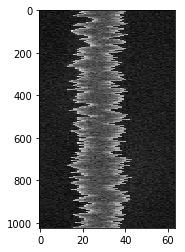

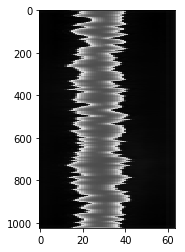

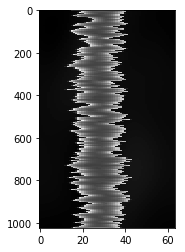

In [73]:
"""
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(-512, 512, 16)
Y = np.arange(-512, 512, 1)
print(X.shape,Y.shape)
X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(imnoisy,X,Y, antialiased=False, cmap = cm.coolwarm)

plt.show()
"""
plt.imshow(imnoisy,cmap = 'gray',aspect= 0.1)
plt.show()

plt.imshow(impredict, cmap = 'gray', aspect= 0.1)
plt.show()

plt.imshow(im,cmap = 'gray',aspect = 0.1)
plt.show()